# 02_clean_uk_housing.ipynb

**Authors:** Natan Wojtowicz

**Purpose / short description:**
This notebook shows the full cleaning + exploratory workflow starting from a prepared CSV/Parquet (for example one of the sample files produced by `01_scrape_uk_housing.ipynb`). At the end it saves a single cleaned Parquet file ready for modeling and a second notebook `03_predict_uk_housing.ipynb` will use it.

This notebook is written with many markdown cells that answer the question "what does this code do?" so anyone in the group can present it during the exam.

## Notebook content

### 1. Setup & load a sample

In [12]:
# Who: Natan
# Purpose: imports and loading a sample dataset
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm
import seaborn as sns

ROOT = Path.cwd()
DATA_DIR = ROOT / 'data' / 'uk_housing' / 'processed' / 'samples'
# Choose your prepared sample file here (created in scrape notebook)
SAMPLE_FILE = DATA_DIR / 'pp_2010_2017.csv'

# Load either parquet or csv
if SAMPLE_FILE.with_suffix('.parquet').exists():
    df = pd.read_parquet(SAMPLE_FILE.with_suffix('.parquet'))
else:
    df = pd.read_csv(SAMPLE_FILE, parse_dates=['Date of Transfer'], low_memory=False)

print('Rows:', len(df))
df.head()

Rows: 6200823


,Transaction unique identifier,Price,Date of Transfer,Property Type,Old/New,Duration,Town/City,District,County,PPDCategory Type,Record Status - monthly file only,date,year
0,{0909AF4E-FCDF-4A1F-8F2B-2E72B95FD344},54000,2010-12-15,T,N,L,SWANSEA,SWANSEA,SWANSEA,A,A,2010-12-15,2010
1,{C19EE7DE-83F7-446B-B80A-2E72D1013976},242950,2010-12-03,F,Y,L,FERNDOWN,EAST DORSET,DORSET,A,A,2010-12-03,2010
2,{89D89B61-0437-413A-A9D1-2E72DBA45D23},220000,2010-02-19,D,Y,F,BRIDGNORTH,SHROPSHIRE,SHROPSHIRE,A,A,2010-02-19,2010
3,{23190476-2BF5-47FC-BE79-275388275836},72000,2010-12-20,T,N,F,SUNDERLAND,SUNDERLAND,TYNE AND WEAR,A,A,2010-12-20,2010
4,{BD55330D-8F32-4162-9DA4-2753920A35B8},159500,2010-12-20,S,N,F,BURNHAM-ON-SEA,SEDGEMOOR,SOMERSET,A,A,2010-12-20,2010


**Explain for oral exam:** We prefer Parquet for subsequent runs. The `low_memory=False` option avoids mixed-type inference but can be heavier.

### 2. Standardize column names


In [13]:
# Who: Natan
# Purpose: remove spaces, lowercase, and normalize column names

def clean_columns(df):
    df = df.copy()
    rename_map = {c: c.strip().lower().replace(' ', '_').replace('/', '_') for c in df.columns}
    df.rename(columns=rename_map, inplace=True)
    return df

df = clean_columns(df)
print(df.columns.tolist())

['transaction_unique_identifier', 'price', 'date_of_transfer', 'property_type', 'old_new', 'duration', 'town_city', 'district', 'county', 'ppdcategory_type', 'record_status_-_monthly_file_only', 'date', 'year']


*Exam explanation:* Replacing spaces and setting lowercase ensures predictable attribute access and consistent pipeline code.

### 3. Basic type casting and parsing


In [14]:
# Who: Natan
# Purpose: cast types, parse dates, create derived columns

# Parse date
if 'date_of_transfer' in df.columns:
    df['date_of_transfer'] = pd.to_datetime(df['date_of_transfer'], errors='coerce')
    df['year'] = df['date_of_transfer'].dt.year

# Price: numeric
if 'price' in df.columns:
    df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Property type / old_new / duration: categorical
for c in ['property_type', 'old_new', 'duration', 'ppdcategory_type']:
    if c in df.columns:
        df[c] = df[c].astype('category')

# Trim whitespace for string columns like town_city, district, county
for c in ['town_city', 'district', 'county']:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().replace({'nan': None})

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6200823 entries, 0 to 6200822
Data columns (total 13 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   transaction_unique_identifier      object        
 1   price                              int64         
 2   date_of_transfer                   datetime64[ns]
 3   property_type                      category      
 4   old_new                            category      
 5   duration                           category      
 6   town_city                          object        
 7   district                           object        
 8   county                             object        
 9   ppdcategory_type                   category      
 10  record_status_-_monthly_file_only  object        
 11  date                               object        
 12  year                               int32         
dtypes: category(4), datetime64[ns](1), int32(1), int64(1), ob

*Exam explanation:* Converting to correct dtypes (datetime, numeric, categorical) improves memory and downstream model handling.

### 4. Missing values analysis and handling


Dropped 0 rows with missing price
Remaining rows after basic na handling: 6200823


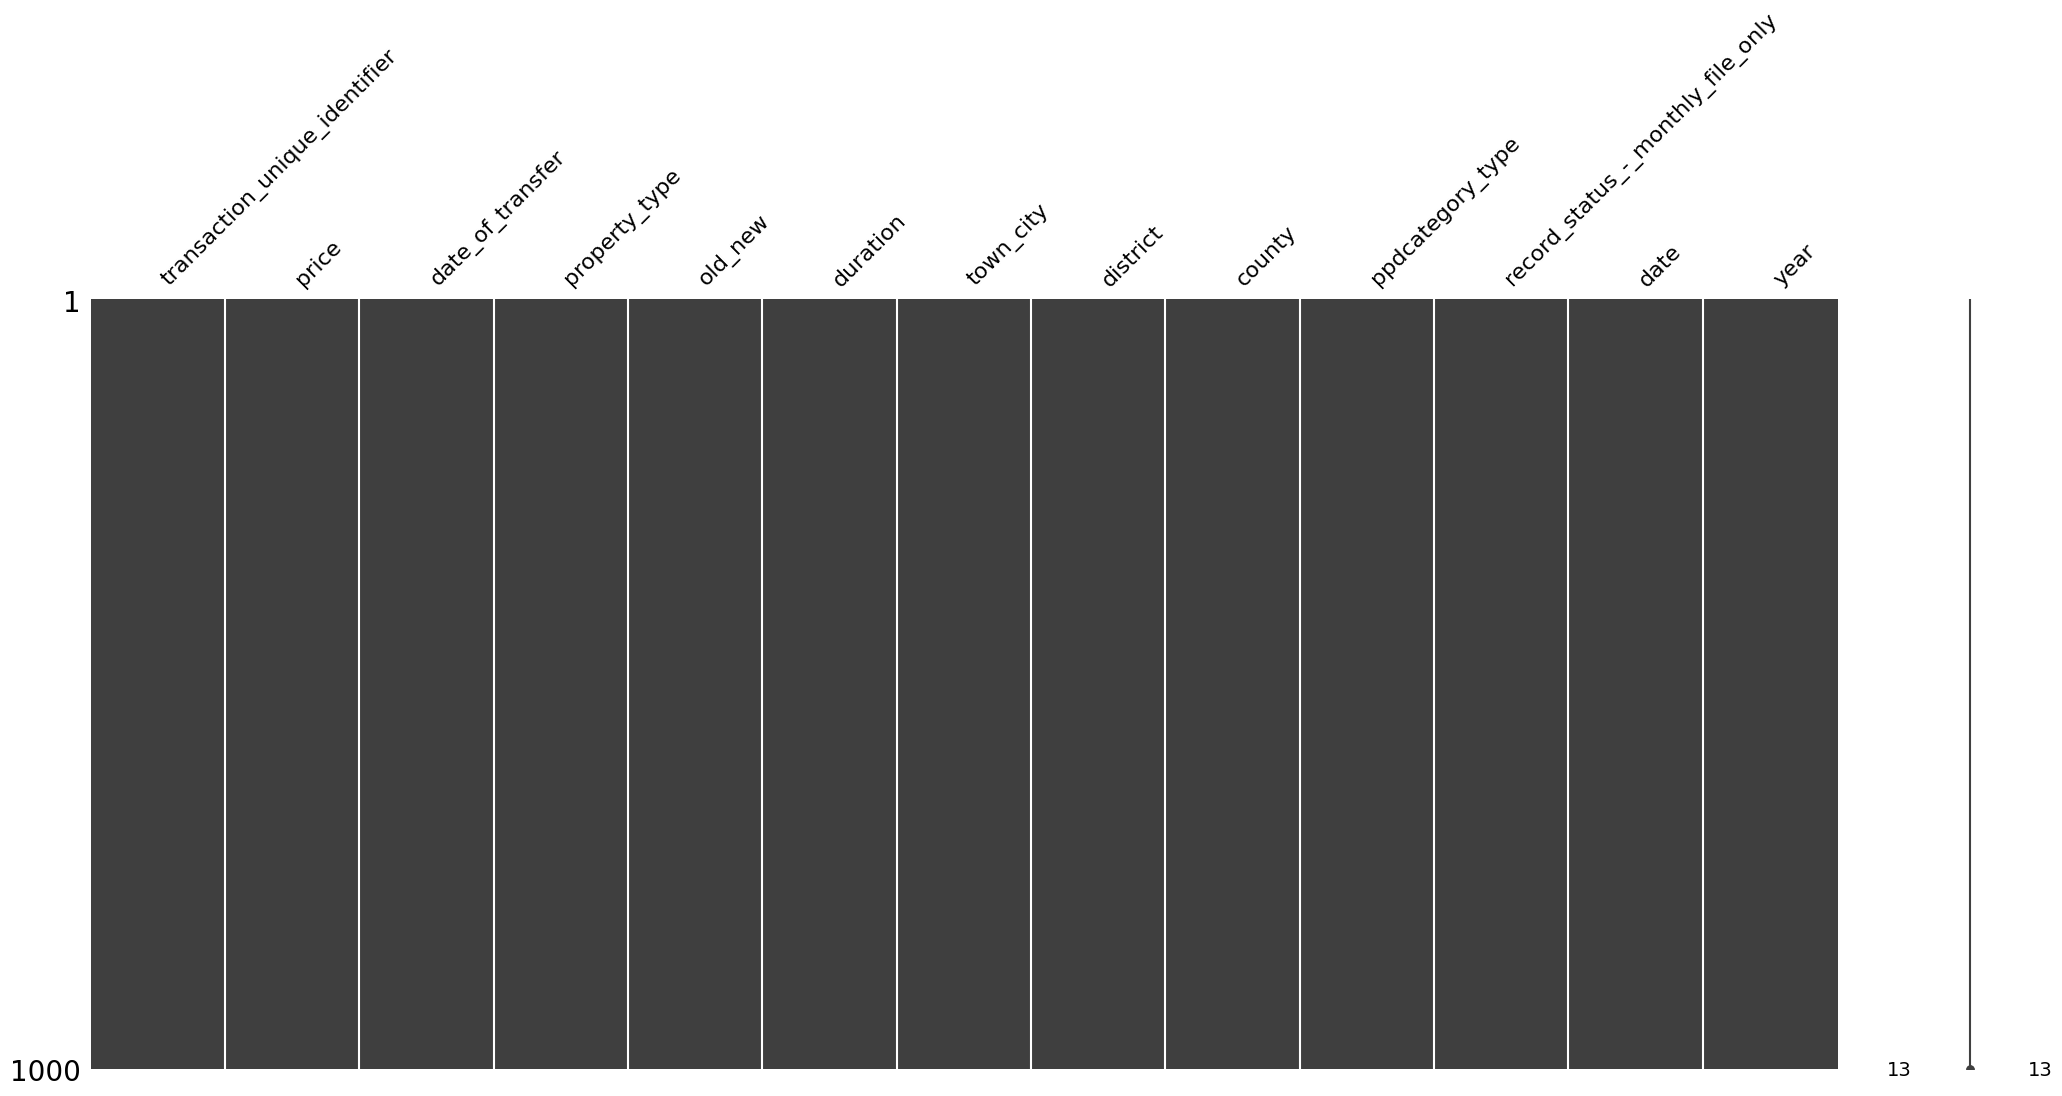

In [16]:
# Who: Natan
# Purpose: show missingness and propose strategies

missing = df.isna().sum().sort_values(ascending=False)
missing[missing>0]

# Visualize missingness quickly
import missingno as msno
msno.matrix(df.sample(min(len(df), 1000)))  # uncomment to visualize

# Strategies (examples):
# - If town/county missing: keep as 'unknown' string
# - If price is missing: drop rows (we're predicting price) or try to infer from similar rows.

# Implement a default strategy
# 1) Drop records with missing price
before = len(df)
df = df[~df['price'].isna()].copy()
after = len(df)
print(f"Dropped {before-after} rows with missing price")

# 2) Fill missing categorical location data with 'Unknown'
for c in ['town_city', 'district', 'county']:
    if c in df.columns:
        df[c] = df[c].fillna('Unknown')

# 3) For date missing: drop (or if few, impute year from file name)
df = df[~df['date_of_transfer'].isna()]

print('Remaining rows after basic na handling:', len(df))

**Explainable note:** You must justify dropping vs imputing. For price prediction, rows without price are of little use; for other tasks they might be important.

### 5. Outlier detection and handling


count    6.200823e+06
mean     2.730926e+05
std      6.953689e+05
min      1.000000e+00
1%       4.200000e+04
5%       7.000000e+04
25%      1.290000e+05
50%      1.920000e+05
75%      2.960000e+05
95%      6.320000e+05
99%      1.365000e+06
max      9.890000e+07
Name: price, dtype: float64


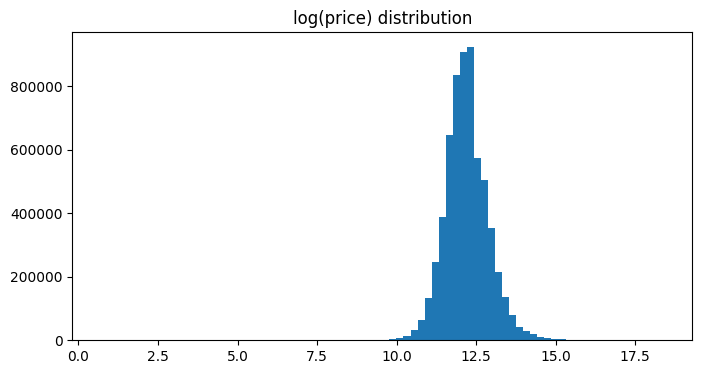

1e-3 quantile: 12000.0 1e-3 upper: 5800000.0
Removing rows with price < 12000.0 or > 5800000.0
Dropped 12305 rows as outliers


In [17]:
# Who: Natan
# Purpose: show price distribution and apply robust winsorization/filters

# Quick stats
print(df['price'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))

# Plot log-price distribution (helps visualizing skew)
plt.figure(figsize=(8,4))
plt.hist(np.log1p(df['price']), bins=80)
plt.title('log(price) distribution')
plt.show()

# Define outlier thresholds: remove extremely small or large prices
q_low, q_high = df['price'].quantile([0.001, 0.999])
print('1e-3 quantile:', q_low, '1e-3 upper:', q_high)

# Option: Winsorize extreme values OR drop beyond thresholds
cut_low = q_low
cut_high = q_high
print('Removing rows with price <', cut_low, 'or >', cut_high)
before = len(df)
df = df[(df['price'] >= cut_low) & (df['price'] <= cut_high)].copy()
print('Dropped', before - len(df), 'rows as outliers')

**Exam talking points:** Explain why log-transforming price is useful (reduces skew), and why extreme outlier removal helps some models but may remove legitimate high-value properties (be prepared to discuss tradeoffs).

### 6. Feature engineering


In [18]:
# Who: Natan
# Purpose: create commonly useful features

# Numeric features: year, month
if 'date_of_transfer' in df.columns:
    df['month'] = df['date_of_transfer'].dt.month.astype('int16')

# Encode property type with meaningful names
property_map = {'D':'Detached','S':'Semi-Detached','T':'Terraced','F':'Flats/Maisonettes','O':'Other'}
if 'property_type' in df.columns:
    df['property_type_label'] = df['property_type'].cat.add_categories(['Unknown']).fillna('Unknown')
    df['property_type_label'] = df['property_type_label'].map(property_map).astype('category')

# Create price per year-normalized or log price
df['log_price'] = np.log1p(df['price'])

# Example aggregate: median price by county & year (useful as a feature)
agg = df.groupby(['county', 'year'])['price'].median().reset_index().rename(columns={'price':'median_price_county_year'})
df = df.merge(agg, how='left', on=['county','year'])

print('Feature engineering complete')

Feature engineering complete


**Explainable:** Group-level aggregates are powerful features to help models capture local price levels.

### 7. Encoding categoricals / preparing final dataset


In [19]:
# Who: Natan
# Purpose: prepare a clean dataset and show example encodings

# Option 1: keep categoricals as pandas categories and let modeling pipeline handle them
cat_cols = [c for c in df.columns if str(df[c].dtype) == 'category']
print('Categorical columns:', cat_cols)

# Option 2: create target encoding or one-hot for small-cardinality columns
# Example: one-hot for property_type_label
one_hot = pd.get_dummies(df['property_type_label'], prefix='ptype')
df = pd.concat([df, one_hot], axis=1)

# Select final columns for modeling
final_cols = ['price', 'log_price', 'year', 'month', 'median_price_county_year', 'town_city', 'county'] + list(one_hot.columns)
final_df = df[final_cols].copy()

print('Final columns:', final_df.columns.tolist())
final_df.head()

Categorical columns: ['property_type', 'old_new', 'duration', 'ppdcategory_type', 'property_type_label']
Final columns: ['price', 'log_price', 'year', 'month', 'median_price_county_year', 'town_city', 'county', 'ptype_Detached', 'ptype_Flats/Maisonettes', 'ptype_Other', 'ptype_Semi-Detached', 'ptype_Terraced']


,price,log_price,year,month,median_price_county_year,town_city,county,ptype_Detached,ptype_Flats/Maisonettes,ptype_Other,ptype_Semi-Detached,ptype_Terraced
0,54000,10.896758,2010,12,129000.0,SWANSEA,SWANSEA,False,False,False,False,True
1,242950,12.400615,2010,12,235000.0,FERNDOWN,DORSET,False,True,False,False,False
2,220000,12.301387,2010,2,172500.0,BRIDGNORTH,SHROPSHIRE,True,False,False,False,False
3,72000,11.184435,2010,12,125000.0,SUNDERLAND,TYNE AND WEAR,False,False,False,False,True
4,159500,11.979805,2010,12,180000.0,BURNHAM-ON-SEA,SOMERSET,False,False,False,True,False


### 8. Save cleaned data


In [20]:
# Who: Natan
# Purpose: save cleaned dataset for modeling
OUT = Path.cwd() / 'data' / 'uk_housing' / 'cleaned'
OUT.mkdir(parents=True, exist_ok=True)

# Save as Parquet
final_path_parquet = OUT / 'uk_housing_cleaned_sample.parquet'
final_df.to_parquet(final_path_parquet, index=False)
print('Saved cleaned file to', final_path_parquet)

# Save as CSV
final_path_csv = OUT / 'uk_housing_cleaned_sample.csv'
final_df.to_csv(final_path_csv, index=False)
print('Saved cleaned file to', final_path_csv)

Saved cleaned file to c:\Users\natan\Desktop\School\3eJaar\ML\Challenge\CloudAikes\dataset_1_uk_housing\data\uk_housing\cleaned\uk_housing_cleaned_sample.parquet
Saved cleaned file to c:\Users\natan\Desktop\School\3eJaar\ML\Challenge\CloudAikes\dataset_1_uk_housing\data\uk_housing\cleaned\uk_housing_cleaned_sample.csv


### 9. Quick EDA plots (to include in the EDA notebook and presentation)


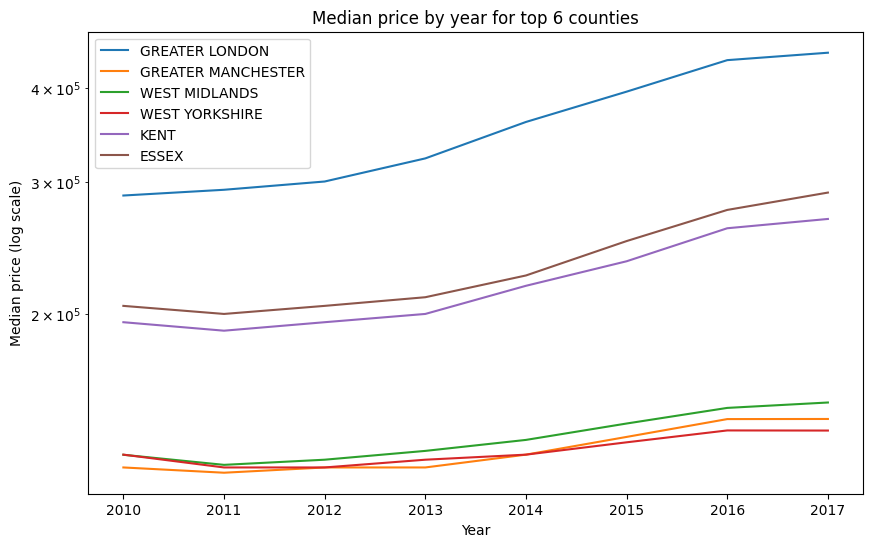

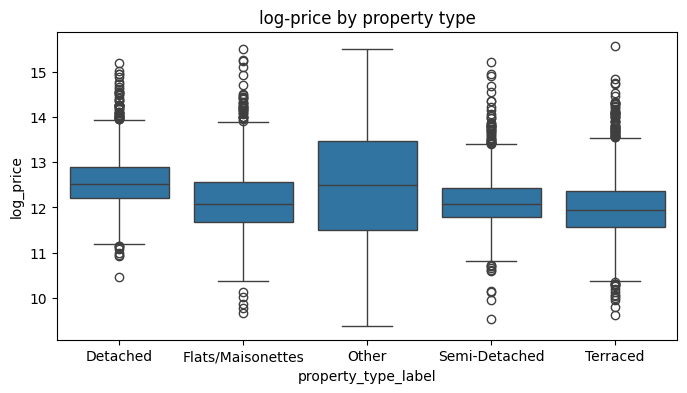

In [21]:
# Who: Natan
# Purpose: create a few quick plots that you can screenshot for the report

# Median price by year for a few counties
counties = df['county'].value_counts().nlargest(6).index.tolist()
plt.figure(figsize=(10,6))
for c in counties:
    s = df[df['county']==c].groupby('year')['price'].median()
    plt.plot(s.index, s.values, label=c)
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Median price (log scale)')
plt.legend()
plt.title('Median price by year for top 6 counties')
plt.show()

# Price distribution by property type (boxplot on log scale)
plt.figure(figsize=(8,4))
sns.boxplot(x='property_type_label', y='log_price', data=df.sample(min(len(df),10000)))
plt.title('log-price by property type')
plt.show()

**Exam tip:** Keep these plots simple and readable — the oral exam will benefit from clear visuals.


### 10. Final notes & checklist to finish cleaning

* Check whether you want to keep Category B transactions (`ppdcategory_type`) — often filter to Category A for standard market transactions.
* Consider whether leasehold vs freehold (`duration`) needs special handling (e.g., encoding or removing non-residential transactions).
* Document any rows you remove and how many you removed; this should be included in the README and EDA notebooks.

# End of notebooks

**What I created for you:** Two complete, runnable notebooks (as markdown + code cells) that the team can execute. They include explanations above code blocks so everyone can explain what the code does during the oral exam.

**Next steps I recommend:**

1. Run the `01_scrape_uk_housing.ipynb` on your machine or a runner with enough disk to download the Kaggle dataset. If you cannot run Kaggle API, upload the CSV to `data/uk_housing/raw/`.
2. Use the produced sample(s) as input to `02_clean_uk_housing.ipynb` and iterate on missing-value and outlier strategies.
3. When ready, tell me and I will produce the `03_predict_uk_housing.ipynb` and `04_deploy_uk_housing.ipynb` notebooks as well.

Good luck — let me know if you want me to also produce the PyCaret tuning notebook next.